# ¿Cuál es la mejor tarifa?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

## Inicialización

In [4]:
# Cargar todas las librerías

from scipy import stats as st
import pandas as pd
import numpy as np
import math as mt
from math import factorial
import seaborn as sns
import matplotlib.pyplot as plt

# Configurar las opciones de visualización
sns.set(style="whitegrid")

## Cargar datos

In [5]:
# Carga los archivos de datos en diferentes DataFrames

megaline_users = pd.read_csv('megaline_users.csv')
megaline_calls = pd.read_csv('megaline_calls.csv')
megaline_messages = pd.read_csv('megaline_messages.csv')
megaline_internet = pd.read_csv('megaline_internet.csv')
megaline_plans = pd.read_csv('megaline_plans.csv')

## Preparar los datos

## Tarifas

In [6]:
# Imprime la información general/resumida sobre el DataFrame de las tarifas

print("Información general sobre el DataFrame de las tarifas:")
print(megaline_plans.info())

Información general sobre el DataFrame de las tarifas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 260.0+ bytes
None


In [7]:
# Imprime una muestra de los datos para las tarifas

print("Muestra de los datos para las tarifas:")
print(megaline_plans.head())


Muestra de los datos para las tarifas:
   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0               20          10             0.03            0.03      surf  
1               70           7             0.01            0.01  ultimate  


Tipos de Datos:

Los tipos de datos parecen ser correctos según lo que se esperaría para cada columna. Las columnas numéricas están adecuadamente en formatos int64 o float64 y la columna plan_name está en formato object.

Valores Nulos:

No hay valores nulos en el DataFrame, lo cual es positivo y sugiere que los datos están completos en cuanto a las entradas.

## Corregir datos

N/A ya que No se observan problemas obvios en los datos.

No hay valores nulos.

Todos los tipos de datos son correctos.

## Enriquecer los datos

Para enriquecer los datos del DataFrame megaline_plans, podemos agregar algunas columnas que pueden ser útiles para el análisis posterior.

1. Costo mensual por minuto adicional:

Calculamos el costo por minuto adicional mensual en caso de que un usuario exceda los minutos incluidos en su plan.

2. Costo mensual por SMS adicional:

Calculamos el costo por SMS adicional mensual en caso de que un usuario exceda los SMS incluidos en su plan.

3. Costo mensual por GB adicional:

Calculamos el costo por GB adicional mensual en caso de que un usuario exceda los datos incluidos en su plan.

In [8]:
megaline_plans['monthly_extra_minute_cost'] = megaline_plans['usd_per_minute'] * megaline_plans['minutes_included']
megaline_plans['monthly_extra_message_cost'] = megaline_plans['usd_per_message'] * megaline_plans['messages_included']
# 1 gigabyte (GB) equivale a 1024 megabytes (MB).
megaline_plans['monthly_extra_gb_cost'] = megaline_plans['usd_per_gb'] * (megaline_plans['mb_per_month_included'] / 1024)

# Imprimir la información del DataFrame enriquecido
print(megaline_plans.head())

   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  \
0               20          10             0.03            0.03      surf   
1               70           7             0.01            0.01  ultimate   

   monthly_extra_minute_cost  monthly_extra_message_cost  \
0                       15.0                         1.5   
1                       30.0                        10.0   

   monthly_extra_gb_cost  
0                  150.0  
1                  210.0  


## Usuarios/as

In [9]:
# Imprime la información general/resumida sobre el DataFrame de usuarios

print("Información general sobre el DataFrame de Usuarios:")
print(megaline_users.info())

Información general sobre el DataFrame de Usuarios:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None


In [10]:
# Imprime una muestra de datos para usuarios

print("Muestra de datos para usuarios:")
print(megaline_users.head())

Muestra de datos para usuarios:
   user_id first_name  last_name  age                                   city  \
0     1000   Anamaria      Bauer   45  Atlanta-Sandy Springs-Roswell, GA MSA   
1     1001     Mickey  Wilkerson   28        Seattle-Tacoma-Bellevue, WA MSA   
2     1002     Carlee    Hoffman   36   Las Vegas-Henderson-Paradise, NV MSA   
3     1003   Reynaldo    Jenkins   52                          Tulsa, OK MSA   
4     1004    Leonila   Thompson   40        Seattle-Tacoma-Bellevue, WA MSA   

     reg_date      plan churn_date  
0  2018-12-24  ultimate        NaN  
1  2018-08-13      surf        NaN  
2  2018-10-21      surf        NaN  
3  2018-01-28      surf        NaN  
4  2018-05-23      surf        NaN  


Observaciones
Tipos de Datos:

Las columnas reg_date y churn_date están en formato object, lo que indica que están almacenadas como cadenas de texto. Sería útil convertirlas a un formato de fecha (datetime) para facilitar el análisis temporal.

Las demás columnas parecen tener los tipos de datos adecuados (int64 para user_id y age, object para nombres, ciudad y plan).

Valores Nulos:

La columna churn_date tiene 34 valores no nulos, lo que significa que solo 34 de los 500 usuarios no se han dado de baja. Esto no es necesariamente un problema, pero es importante tenerlo en cuenta en el análisis.

### Corregir los datos

In [11]:
# Convertir las columnas de fecha a tipo datetime
megaline_users['reg_date'] = pd.to_datetime(megaline_users['reg_date'])
megaline_users['churn_date'] = pd.to_datetime(megaline_users['churn_date'])

# Imprimir la información general después de la corrección
print("Información general después de la corrección:")
print(megaline_users.info())

# Imprimir una muestra de los datos después de la corrección
print("\nMuestra de los datos después de la corrección:")
print(megaline_users.head())


Información general después de la corrección:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB
None

Muestra de los datos después de la corrección:
   user_id first_name  last_name  age                                   city  \
0     1000   Anamaria      Bauer   45  Atlanta-Sandy Springs-Roswell, GA MSA   
1     1001     Mickey  Wilkerson   28        Seattle-Tacoma-Bellevue, WA MSA   
2     1

### Enriquecer los datos

Duración de la suscripción:

Calculamos el tiempo que cada usuario ha estado suscrito al servicio.

Edad en grupos: Agrupamos las edades en categorías, como jóvenes (18-25), adultos jóvenes (26-35), adultos (36-50), y mayores (51+).

se está aplicando pd.cut a la columna age para agrupar las edades en rangos definidos por la lista bins. Luego, a cada rango se le asigna una etiqueta específica a través del parámetro labels. 


El parámetro right=False en pd.cut indica que los intervalos serán cerrados por la izquierda y abiertos por la derecha. Esto significa que, en cada bin, se incluye el límite inferior pero se excluye el límite superior.

In [12]:
# Añadir la columna de duración de la suscripción en días
megaline_users['subscription_duration_days'] = (megaline_users['churn_date'].fillna(pd.Timestamp('2018-12-31')) - megaline_users['reg_date']).dt.days

bins = [18, 25, 35, 50, 100]
labels = ['Jóvenes (18-25)', 'Adultos jóvenes (26-35)', 'Adultos (36-50)', 'Mayores (51+)']
megaline_users['age_group'] = pd.cut(megaline_users['age'], bins=bins, labels=labels, right=False)

# Imprimir la información del DataFrame enriquecido
print(megaline_users.head())

   user_id first_name  last_name  age                                   city  \
0     1000   Anamaria      Bauer   45  Atlanta-Sandy Springs-Roswell, GA MSA   
1     1001     Mickey  Wilkerson   28        Seattle-Tacoma-Bellevue, WA MSA   
2     1002     Carlee    Hoffman   36   Las Vegas-Henderson-Paradise, NV MSA   
3     1003   Reynaldo    Jenkins   52                          Tulsa, OK MSA   
4     1004    Leonila   Thompson   40        Seattle-Tacoma-Bellevue, WA MSA   

    reg_date      plan churn_date  subscription_duration_days  \
0 2018-12-24  ultimate        NaT                           7   
1 2018-08-13      surf        NaT                         140   
2 2018-10-21      surf        NaT                          71   
3 2018-01-28      surf        NaT                         337   
4 2018-05-23      surf        NaT                         222   

                 age_group  
0          Adultos (36-50)  
1  Adultos jóvenes (26-35)  
2          Adultos (36-50)  
3           

## Llamadas

In [13]:
# Imprime la información general/resumida sobre el DataFrame de las llamadas

print("Información general sobre el DataFrame de las llamadas:")
print(megaline_calls.info())

Información general sobre el DataFrame de las llamadas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB
None


In [14]:
# Imprime una muestra de datos para las llamadas

print("Muestra de datos para las llamadas:")
print(megaline_calls.head())


Muestra de datos para las llamadas:
         id  user_id   call_date  duration
0   1000_93     1000  2018-12-27      8.52
1  1000_145     1000  2018-12-27     13.66
2  1000_247     1000  2018-12-27     14.48
3  1000_309     1000  2018-12-28      5.76
4  1000_380     1000  2018-12-30      4.22


Observaciones
Tipos de Datos:

La columna call_date está en formato object, lo que sugiere que las fechas están almacenadas como cadenas de texto. Para análisis temporales más precisos, sería útil convertir esta columna a formato de fecha (datetime).

Valores Nulos:

No se observan valores nulos en ninguna de las columnas del DataFrame. Esto es positivo y sugiere que los datos están completos en cuanto a las entradas.

Acciones para Corregir y Enriquecer los Datos
Convertir Columnas de Fecha:

Convertir call_date a formato de fecha (datetime) para facilitar el análisis temporal.

### Corregir los datos

In [15]:
# Convertir la columna de fecha a tipo datetime
megaline_calls['call_date'] = pd.to_datetime(megaline_calls['call_date'])

# Imprimir la información general después de la corrección
print("Información general después de la corrección:")
print(megaline_calls.info())

# Imprimir una muestra de los datos después de la corrección
print("\nMuestra de los datos después de la corrección:")
print(megaline_calls.head())


Información general después de la corrección:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB
None

Muestra de los datos después de la corrección:
         id  user_id  call_date  duration
0   1000_93     1000 2018-12-27      8.52
1  1000_145     1000 2018-12-27     13.66
2  1000_247     1000 2018-12-27     14.48
3  1000_309     1000 2018-12-28      5.76
4  1000_380     1000 2018-12-30      4.22


### Enriquecer los datos

Enriquecer los datos
Podemos agregar algunos factores adicionales a los datos si creemos que pudieran ser útiles. Por ejemplo:

1. Mes de la llamada y día de la semana

2. Duración de llamada categorizada: Clasificamos las llamadas en cortas (menos de 5 minutos), medianas (5-10 minutos), y largas (más de 10 minutos).

En Pandas, `.dt.dayofweek` es una propiedad del accesor `.dt` que devuelve el día de la semana como un número (donde 0 es lunes y 6 es domingo). Por otro lado, `dow` es simplemente una abreviatura común para “day of week” (día de la semana) y no es un atributo nativo del objeto datetime de Pandas; a veces se utiliza como alias o nombre de columna para almacenar el resultado de `.dt.dayofweek`.

In [16]:
# Añadir la columna del mes de la llamada
megaline_calls['month'] = megaline_calls['call_date'].dt.month

# Añadir la columna del día de la semana de la llamada
megaline_calls['day_of_week'] = megaline_calls['call_date'].dt.dayofweek

megaline_calls['call_duration_category'] = pd.cut(megaline_calls['duration'],
                                           bins=[0, 5, 10, float('inf')], labels=['Corta', 'Mediana', 'Larga'], right=False)

# Imprimir la información del DataFrame enriquecido
print(megaline_calls.head())

         id  user_id  call_date  duration  month  day_of_week  \
0   1000_93     1000 2018-12-27      8.52     12            3   
1  1000_145     1000 2018-12-27     13.66     12            3   
2  1000_247     1000 2018-12-27     14.48     12            3   
3  1000_309     1000 2018-12-28      5.76     12            4   
4  1000_380     1000 2018-12-30      4.22     12            6   

  call_duration_category  
0                Mediana  
1                  Larga  
2                  Larga  
3                Mediana  
4                  Corta  


## Mensajes

In [17]:
# Imprime la información general/resumida sobre el DataFrame de los mensajes

print("Información general sobre el DataFrame de los mensajes:")
print(megaline_messages.info())

Información general sobre el DataFrame de los mensajes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB
None


In [18]:
# Imprime una muestra de datos para los mensajes

print("Muestra de datos para los mensajes:")
print(megaline_messages.head())

Muestra de datos para los mensajes:
         id  user_id message_date
0  1000_125     1000   2018-12-27
1  1000_160     1000   2018-12-31
2  1000_223     1000   2018-12-31
3  1000_251     1000   2018-12-27
4  1000_255     1000   2018-12-26


### Corregir los datos

In [19]:
megaline_messages['message_date'] = pd.to_datetime(megaline_messages['message_date'])
print(megaline_messages.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB
None


### Enriquecer los datos

En este código, se utiliza la función count dentro del método .agg({'id': 'count'}) para contar el número de registros en la columna id para cada grupo formado por user_id y message_date. Esto significa que, para cada combinación única de usuario y fecha, se cuenta cuántas entradas (o mensajes) existen en la columna id. Es importante destacar que count únicamente cuenta los valores que no son nulos, por lo que si hay valores nulos en id, estos serán ignorados. Finalmente, se renombra la columna resultante a messages_sent_per_day para indicar claramente que se trata de la cantidad de mensajes enviados por día para cada usuario.

In [20]:
# Añadir la columna del mes del mensaje
megaline_messages['month'] = megaline_messages['message_date'].dt.month

# Añadir la columna del día de la semana del mensaje
megaline_messages['day_of_week'] = megaline_messages['message_date'].dt.dayofweek

messages_per_day = megaline_messages.groupby(['user_id', 'message_date']).agg({'id': 'count'}).reset_index()
messages_per_day.rename(columns={'id': 'messages_sent_per_day'}, inplace=True)
print(messages_per_day.head())

# Imprimir la información del DataFrame enriquecido
print(megaline_messages.head())


   user_id message_date  messages_sent_per_day
0     1000   2018-12-25                      1
1     1000   2018-12-26                      1
2     1000   2018-12-27                      3
3     1000   2018-12-28                      1
4     1000   2018-12-29                      1
         id  user_id message_date  month  day_of_week
0  1000_125     1000   2018-12-27     12            3
1  1000_160     1000   2018-12-31     12            0
2  1000_223     1000   2018-12-31     12            0
3  1000_251     1000   2018-12-27     12            3
4  1000_255     1000   2018-12-26     12            2


## Internet

In [21]:
# Imprime la información general/resumida sobre el DataFrame de internet

print("Información general sobre el DataFrame de internet:")
print(megaline_internet.info())

Información general sobre el DataFrame de internet:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB
None


In [22]:
# Imprime una muestra de datos para el tráfico de internet

print("Muestra de datos para el tráfico de internet:")
print(megaline_internet.head())

Muestra de datos para el tráfico de internet:
         id  user_id session_date  mb_used
0   1000_13     1000   2018-12-29    89.86
1  1000_204     1000   2018-12-31     0.00
2  1000_379     1000   2018-12-28   660.40
3  1000_413     1000   2018-12-26   270.99
4  1000_442     1000   2018-12-27   880.22


### Corregir los datos

In [23]:
megaline_internet['session_date'] = pd.to_datetime(megaline_internet['session_date'])

print(megaline_internet.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB
None


### Enriquecer los datos

Podemos agregar el mes y día de la sesión.

Uso de datos por sesión categorizado:
Clasificamos las sesiones de internet en ligeras (menos de 200 MB), moderadas (200-500 MB), y pesadas (más de 500 MB).

Se utiliza float('inf') para definir el límite superior del último bin, es decir, "infinito". De esta forma, cualquier valor de mb_used que sea mayor o igual a 500 se incluirá en la categoría "Pesada". Esto asegura que todos los datos por encima de 500, sin importar qué tan altos sean, queden correctamente clasificados en esa categoría


In [24]:
# Añadir la columna del mes de la sesión
megaline_internet['month'] = megaline_internet['session_date'].dt.month

# Añadir la columna del día de la semana de la sesión
megaline_internet['day_of_week'] = megaline_internet['session_date'].dt.dayofweek

megaline_internet['session_data_category'] = pd.cut(megaline_internet['mb_used'], bins=[0, 200, 500, float('inf')],
                                           labels=['Ligera', 'Moderada', 'Pesada'], right=False)

# Imprimir la información del DataFrame enriquecido
print(megaline_internet.head())

         id  user_id session_date  mb_used  month  day_of_week  \
0   1000_13     1000   2018-12-29    89.86     12            5   
1  1000_204     1000   2018-12-31     0.00     12            0   
2  1000_379     1000   2018-12-28   660.40     12            4   
3  1000_413     1000   2018-12-26   270.99     12            2   
4  1000_442     1000   2018-12-27   880.22     12            3   

  session_data_category  
0                Ligera  
1                Ligera  
2                Pesada  
3              Moderada  
4                Pesada  


## Estudiar las condiciones de las tarifas

Descripción de las tarifas Surf y Ultimate
Tarifa Surf
Pago mensual: $20

Incluye:

500 minutos al mes

50 SMS al mes

15 GB de datos al mes (15360 MB)

Costos adicionales:

Minuto extra: $0.03

SMS extra: $0.03

GB extra: $10 (1 GB = 1024 MB)

Tarifa Ultimate
Pago mensual: $70

Incluye:

3000 minutos al mes

1000 SMS al mes

30 GB de datos al mes (30720 MB)

Costos adicionales:

Minuto extra: $0.01

SMS extra: $0.01

GB extra: $7 (1 GB = 1024 MB)

Entendiendo las condiciones de las tarifas
Tarifa Surf:

Los usuarios pagan $20 mensuales.

Si un usuario supera los 500 minutos en un mes, paga $0.03 por cada minuto adicional.

Si un usuario supera los 50 SMS en un mes, paga $0.03 por cada SMS adicional.

Si un usuario supera los 15 GB en un mes, paga $10 por cada GB adicional (redondeado hacia arriba).

Tarifa Ultimate:

Los usuarios pagan $70 mensuales.

Si un usuario supera los 3000 minutos en un mes, paga $0.01 por cada minuto adicional.

Si un usuario supera los 1000 SMS en un mes, paga $0.01 por cada SMS adicional.

Si un usuario supera los 30 GB en un mes, paga $7 por cada GB adicional (redondeado hacia arriba).

In [25]:
# Imprime las condiciones de la tarifa y asegúrate de que te quedan claras

print("Condiciones de la tarifa:")
print(megaline_plans)

Condiciones de la tarifa:
   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  \
0               20          10             0.03            0.03      surf   
1               70           7             0.01            0.01  ultimate   

   monthly_extra_minute_cost  monthly_extra_message_cost  \
0                       15.0                         1.5   
1                       30.0                        10.0   

   monthly_extra_gb_cost  
0                  150.0  
1                  210.0  


Resumen
La tarifa Surf tiene un pago mensual más bajo y límites menores, pero los costos adicionales son más altos comparados con Ultimate. Por otro lado, la tarifa Ultimate tiene un pago mensual más alto y límites más generosos, pero los costos adicionales son menores.


## Agregar datos por usuario

In [26]:
display(megaline_calls.head(10))

,id,user_id,call_date,duration,month,day_of_week,call_duration_category
0,1000_93,1000,2018-12-27,8.52,12,3,Mediana
1,1000_145,1000,2018-12-27,13.66,12,3,Larga
2,1000_247,1000,2018-12-27,14.48,12,3,Larga
3,1000_309,1000,2018-12-28,5.76,12,4,Mediana
4,1000_380,1000,2018-12-30,4.22,12,6,Corta
5,1000_388,1000,2018-12-31,2.20,12,0,Corta
6,1000_510,1000,2018-12-27,5.75,12,3,Mediana
7,1000_521,1000,2018-12-28,14.18,12,4,Larga
8,1000_530,1000,2018-12-28,5.77,12,4,Mediana
9,1000_544,1000,2018-12-26,4.40,12,2,Corta


In [ ]:
# Calcula el número de llamadas hechas por cada usuario al mes. 

megaline_calls['month'] = megaline_calls['call_date'].dt.month
calls_per_month = megaline_calls.groupby(['user_id', 'month']).agg({'id': 'count'}).reset_index()
calls_per_month.rename(columns={'id': 'calls_made'}, inplace=True)

print(calls_per_month.head())


   user_id  month  calls_made
0     1000     12          16
1     1001      8          27
2     1001      9          49
3     1001     10          65
4     1001     11          64


In [ ]:
# Calcula la cantidad de minutos usados por cada usuario al mes.

minutes_per_month = megaline_calls.groupby(['user_id', 'month']).agg({'duration': 'sum'}).reset_index()
minutes_per_month.rename(columns={'duration': 'minutes_used'}, inplace=True)

print(minutes_per_month.head())


   user_id  month  minutes_used
0     1000     12        116.83
1     1001      8        171.14
2     1001      9        297.69
3     1001     10        374.11
4     1001     11        404.59


In [45]:
display(megaline_messages.head(10))

,id,user_id,message_date,month,day_of_week
0,1000_125,1000,2018-12-27,12,3
1,1000_160,1000,2018-12-31,12,0
2,1000_223,1000,2018-12-31,12,0
3,1000_251,1000,2018-12-27,12,3
4,1000_255,1000,2018-12-26,12,2
5,1000_346,1000,2018-12-29,12,5
6,1000_386,1000,2018-12-30,12,6
7,1000_413,1000,2018-12-31,12,0
8,1000_502,1000,2018-12-27,12,3
9,1000_525,1000,2018-12-28,12,4


In [ ]:
# Calcula el número de mensajes enviados por cada usuario al mes.

megaline_messages['month'] = megaline_messages['message_date'].dt.month
messages_per_month = megaline_messages.groupby(['user_id', 'month']).agg({'id': 'count'}).reset_index()
messages_per_month.rename(columns={'id': 'messages_sent'}, inplace=True)

print(messages_per_month.head())

   user_id  month  messages_sent
0     1000     12             11
1     1001      8             30
2     1001      9             44
3     1001     10             53
4     1001     11             36


In [46]:
display(megaline_internet.head(10))

,id,user_id,session_date,mb_used,month,day_of_week,session_data_category
0,1000_13,1000,2018-12-29,89.86,12,5,Ligera
1,1000_204,1000,2018-12-31,0.00,12,0,Ligera
2,1000_379,1000,2018-12-28,660.40,12,4,Pesada
3,1000_413,1000,2018-12-26,270.99,12,2,Moderada
4,1000_442,1000,2018-12-27,880.22,12,3,Pesada
5,1001_0,1001,2018-08-24,284.68,8,4,Moderada
6,1001_3,1001,2018-12-09,656.04,12,6,Pesada
7,1001_4,1001,2018-11-04,16.97,11,6,Ligera
8,1001_10,1001,2018-11-27,135.18,11,1,Ligera
9,1001_15,1001,2018-12-13,761.92,12,3,Pesada


In [ ]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. 

megaline_internet['month'] = megaline_internet['session_date'].dt.month
internet_per_month = megaline_internet.groupby(['user_id', 'month']).agg({'mb_used': 'sum'}).reset_index()
internet_per_month.rename(columns={'mb_used': 'mb_used_per_month'}, inplace=True)

print(internet_per_month.head())

   user_id  month  mb_used_per_month
0     1000     12            1901.47
1     1001      8            6919.15
2     1001      9           13314.82
3     1001     10           22330.49
4     1001     11           18504.30


In [47]:
display(megaline_users.head(10))

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,subscription_duration_days,age_group
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT,7,Adultos (36-50)
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,140,Adultos jóvenes (26-35)
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaT,71,Adultos (36-50)
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaT,337,Mayores (51+)
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaT,222,Adultos (36-50)
5,1005,Livia,Shields,31,"Dallas-Fort Worth-Arlington, TX MSA",2018-11-29,surf,NaT,32,Adultos jóvenes (26-35)
6,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18,21,Mayores (51+)
7,1007,Eusebio,Welch,42,"Grand Rapids-Kentwood, MI MSA",2018-07-11,surf,NaT,173,Adultos (36-50)
8,1008,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,NaT,150,Mayores (51+)
9,1009,Gerry,Little,19,"San Jose-Sunnyvale-Santa Clara, CA MSA",2018-04-22,surf,NaT,253,Jóvenes (18-25)


In [31]:
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month

user_data = megaline_users[['user_id', 'plan']]

# Combinar datos de llamadas, minutos, mensajes e internet
user_data = user_data.merge(calls_per_month, on='user_id', how='left')
user_data = user_data.merge(minutes_per_month, on=['user_id', 'month'], how='left')
user_data = user_data.merge(messages_per_month, on=['user_id', 'month'], how='left')
user_data = user_data.merge(internet_per_month, on=['user_id', 'month'], how='left')

print(user_data.head())

   user_id      plan  month  calls_made  minutes_used  messages_sent  \
0     1000  ultimate   12.0        16.0        116.83           11.0   
1     1001      surf    8.0        27.0        171.14           30.0   
2     1001      surf    9.0        49.0        297.69           44.0   
3     1001      surf   10.0        65.0        374.11           53.0   
4     1001      surf   11.0        64.0        404.59           36.0   

   mb_used_per_month  
0            1901.47  
1            6919.15  
2           13314.82  
3           22330.49  
4           18504.30  


In [50]:
display(user_data.head(10))

,user_id,plan,month,calls_made,minutes_used,messages_sent,mb_used_per_month,messages_included,mb_per_month_included,minutes_included,...,monthly_extra_minute_cost,monthly_extra_message_cost,monthly_extra_gb_cost,extra_minutes,extra_messages,extra_gb,extra_minutes_cost,extra_messages_cost,extra_gb_cost,monthly_revenue
0,1000,ultimate,12.0,16.0,116.83,11.0,1901.47,1000,30720,3000,...,30.0,10.0,210.0,0.0,0.0,0.000000,0.00,0.00,0.000000,70.00
1,1001,surf,8.0,27.0,171.14,30.0,6919.15,50,15360,500,...,15.0,1.5,150.0,0.0,0.0,0.000000,0.00,0.00,0.000000,20.00
2,1001,surf,9.0,49.0,297.69,44.0,13314.82,50,15360,500,...,15.0,1.5,150.0,0.0,0.0,0.000000,0.00,0.00,0.000000,20.00
3,1001,surf,10.0,65.0,374.11,53.0,22330.49,50,15360,500,...,15.0,1.5,150.0,0.0,3.0,6.807119,0.00,0.09,68.071191,20.00
4,1001,surf,11.0,64.0,404.59,36.0,18504.30,50,15360,500,...,15.0,1.5,150.0,0.0,0.0,3.070605,0.00,0.00,30.706055,20.00
5,1001,surf,12.0,56.0,392.93,44.0,19369.18,50,15360,500,...,15.0,1.5,150.0,0.0,0.0,3.915215,0.00,0.00,39.152148,20.00
6,1002,surf,10.0,11.0,54.13,15.0,6552.01,50,15360,500,...,15.0,1.5,150.0,0.0,0.0,0.000000,0.00,0.00,0.000000,20.00
7,1002,surf,11.0,55.0,359.76,32.0,19345.08,50,15360,500,...,15.0,1.5,150.0,0.0,0.0,3.891680,0.00,0.00,38.916797,20.00
8,1002,surf,12.0,47.0,363.24,41.0,14396.24,50,15360,500,...,15.0,1.5,150.0,0.0,0.0,0.000000,0.00,0.00,0.000000,20.00
9,1003,surf,12.0,149.0,1041.00,50.0,27044.14,50,15360,500,...,15.0,1.5,150.0,541.0,0.0,11.410293,16.23,0.00,114.102930,36.23


In [49]:
display(megaline_plans.head(10))

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,monthly_extra_minute_cost,monthly_extra_message_cost,monthly_extra_gb_cost
0,50,15360,500,20,10,0.03,0.03,surf,15.0,1.5,150.0
1,1000,30720,3000,70,7,0.01,0.01,ultimate,30.0,10.0,210.0


In [32]:
# Añade la información de la tarifa/Plan

# Fusionar la información de la tarifa
user_data = user_data.merge(megaline_plans, left_on='plan', right_on='plan_name', how='left')

# Mostrar el DataFrame resultante
print(user_data.head())


   user_id      plan  month  calls_made  minutes_used  messages_sent  \
0     1000  ultimate   12.0        16.0        116.83           11.0   
1     1001      surf    8.0        27.0        171.14           30.0   
2     1001      surf    9.0        49.0        297.69           44.0   
3     1001      surf   10.0        65.0        374.11           53.0   
4     1001      surf   11.0        64.0        404.59           36.0   

   mb_used_per_month  messages_included  mb_per_month_included  \
0            1901.47               1000                  30720   
1            6919.15                 50                  15360   
2           13314.82                 50                  15360   
3           22330.49                 50                  15360   
4           18504.30                 50                  15360   

   minutes_included  usd_monthly_pay  usd_per_gb  usd_per_message  \
0              3000               70           7             0.01   
1               500             

[Calcula los ingresos mensuales por usuario (resta el límite del paquete gratuito del número total de llamadas, mensajes de texto y datos; multiplica el resultado por el valor del plan de llamadas; añade la tarifa mensual en función del plan de llamadas). Nota: Dadas las condiciones del plan, ¡esto podría no ser tan trivial como un par de líneas! Así que no pasa nada si dedicas algo de tiempo a ello.]

In [33]:
# Calcula el ingreso mensual para cada usuario

# Calcular exceso de minutos, mensajes y datos
user_data['extra_minutes'] = user_data['minutes_used'] - user_data['minutes_included']
user_data['extra_minutes'] = user_data['extra_minutes'].apply(lambda x: x if x > 0 else 0)

user_data['extra_messages'] = user_data['messages_sent'] - user_data['messages_included']
user_data['extra_messages'] = user_data['extra_messages'].apply(lambda x: x if x > 0 else 0)

user_data['extra_gb'] = (user_data['mb_used_per_month'] / 1024) - (user_data['mb_per_month_included'] / 1024)
user_data['extra_gb'] = user_data['extra_gb'].apply(lambda x: x if x > 0 else 0)

# Calcular el costo adicional
user_data['extra_minutes_cost'] = user_data['extra_minutes'] * user_data['usd_per_minute']
user_data['extra_messages_cost'] = user_data['extra_messages'] * user_data['usd_per_message']
user_data['extra_gb_cost'] = user_data['extra_gb'] * user_data['usd_per_gb']

# Calcular el ingreso mensual total
user_data['monthly_revenue'] = user_data['usd_monthly_pay'] + user_data['extra_minutes_cost']
+ user_data['extra_messages_cost'] + user_data['extra_gb_cost']

# Mostrar las primeras filas del DataFrame resultante
print(user_data[['user_id', 'month', 'plan', 'monthly_revenue']].head())


   user_id  month      plan  monthly_revenue
0     1000   12.0  ultimate             70.0
1     1001    8.0      surf             20.0
2     1001    9.0      surf             20.0
3     1001   10.0      surf             20.0
4     1001   11.0      surf             20.0


## Estudia el comportamiento de usuario

### Llamadas

        plan  month  average_call_duration
0       surf    1.0             192.840000
1       surf    2.0             280.851111
2       surf    3.0             310.970000
3       surf    4.0             332.380000
4       surf    5.0             387.108000
5       surf    6.0             411.450625
6       surf    7.0             428.060917
7       surf    8.0             394.474717
8       surf    9.0             397.133298
9       surf   10.0             414.435733
10      surf   11.0             408.255415
11      surf   12.0             457.547074
12  ultimate    1.0             183.162500
13  ultimate    2.0             443.171667
14  ultimate    3.0             285.701667
15  ultimate    4.0             316.508095
16  ultimate    5.0             383.664828
17  ultimate    6.0             365.358222
18  ultimate    7.0             403.767288
19  ultimate    8.0             397.274789
20  ultimate    9.0             413.287326
21  ultimate   10.0             429.217238
22  ultimat

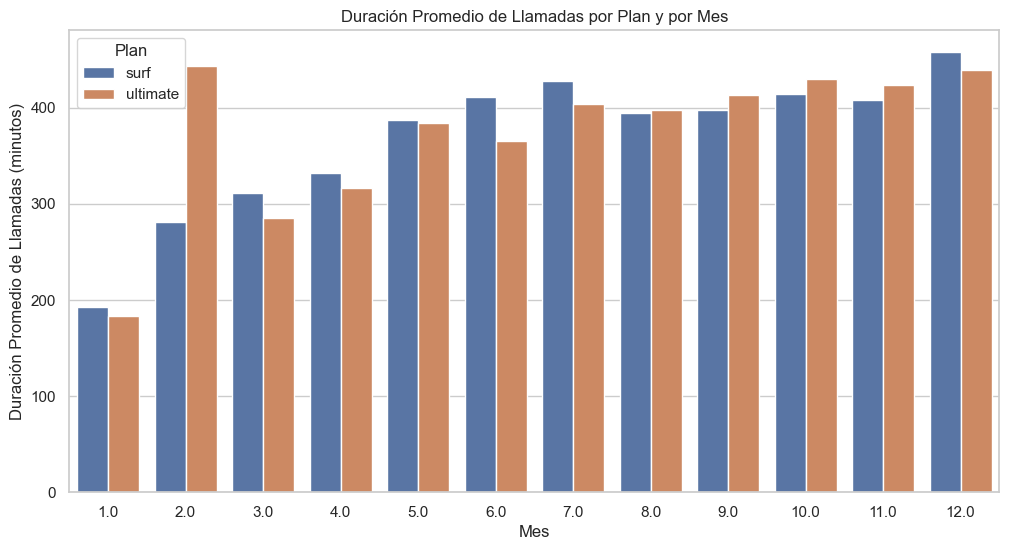

In [34]:
# Compara la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.

# Calcular la duración promedio de llamadas por cada plan y por cada mes
average_call_duration = user_data.groupby(['plan', 'month']).agg({'minutes_used': 'mean'}).reset_index()
average_call_duration.rename(columns={'minutes_used': 'average_call_duration'}, inplace=True)
print(average_call_duration)

# Gráfico de barras de la duración promedio de llamadas por cada plan y por cada mes
plt.figure(figsize=(12, 6))
sns.barplot(data=average_call_duration, x='month', y='average_call_duration', hue='plan')
plt.title('Duración Promedio de Llamadas por Plan y por Mes')
plt.xlabel('Mes')
plt.ylabel('Duración Promedio de Llamadas (minutos)')
plt.legend(title='Plan')
plt.show()

        plan  month  minutes_used
0       surf    1.0        385.68
1       surf    2.0       2527.66
2       surf    3.0       7152.31
3       surf    4.0      16619.00
4       surf    5.0      29033.10
5       surf    6.0      39499.26
6       surf    7.0      51367.31
7       surf    8.0      62721.48
8       surf    9.0      75852.46
9       surf   10.0      96149.09
10      surf   11.0     113086.75
11      surf   12.0     142297.14
12  ultimate    1.0        732.65
13  ultimate    2.0       2659.03
14  ultimate    3.0       3428.42
15  ultimate    4.0       6646.67
16  ultimate    5.0      11126.28
17  ultimate    6.0      16441.12
18  ultimate    7.0      23822.27
19  ultimate    8.0      28206.51
20  ultimate    9.0      35542.71
21  ultimate   10.0      45067.81
22  ultimate   11.0      53400.65
23  ultimate   12.0      65384.90


C:\Users\aleco\AppData\Local\Temp\ipykernel_10616\1165359559.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Plan')


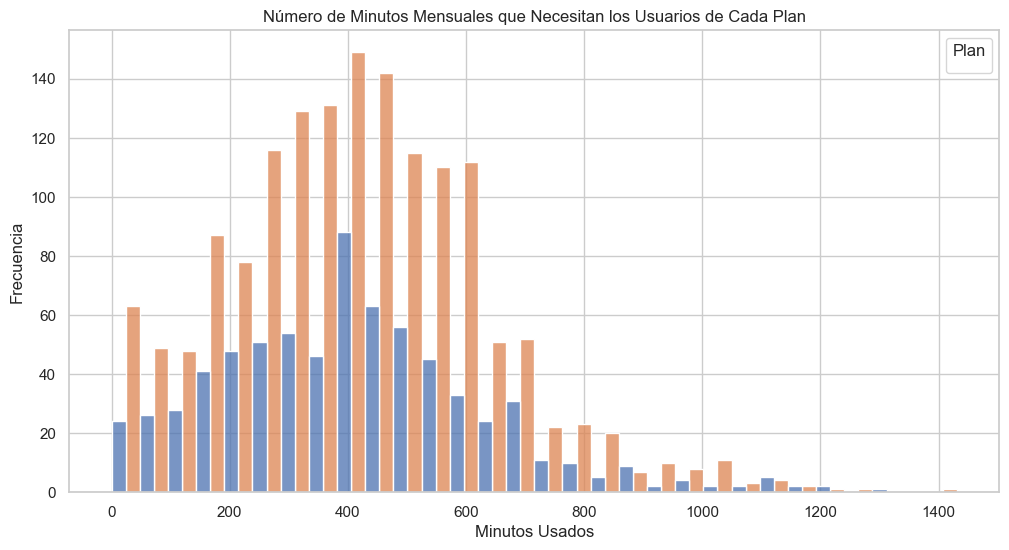

In [35]:
# Compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.

# Calcular la cantidad total de minutos por cada plan y por cada mes
total_minutes_per_plan = user_data.groupby(['plan', 'month']).agg({'minutes_used': 'sum'}).reset_index()
print(total_minutes_per_plan)

# Histograma del número de minutos mensuales que necesitan los usuarios de cada plan
plt.figure(figsize=(12, 6))
sns.histplot(data=user_data, x='minutes_used', hue='plan', multiple='dodge', bins=30)
plt.title('Número de Minutos Mensuales que Necesitan los Usuarios de Cada Plan')
plt.xlabel('Minutos Usados')
plt.ylabel('Frecuencia')
plt.legend(title='Plan')
plt.show()


In [36]:
# Calcula la media y la varianza de la duración mensual de llamadas por plan y por mes.

call_duration_stats = user_data.groupby(['plan', 'month']).agg({'minutes_used': ['mean', 'var']}).reset_index()
call_duration_stats.columns = ['plan', 'month', 'mean_call_duration', 'var_call_duration']

print(call_duration_stats)

        plan  month  mean_call_duration  var_call_duration
0       surf    1.0          192.840000       14795.440200
1       surf    2.0          280.851111       46959.219961
2       surf    3.0          310.970000       31821.317991
3       surf    4.0          332.380000       45615.666796
4       surf    5.0          387.108000       50778.127459
5       surf    6.0          411.450625       39424.054023
6       surf    7.0          428.060917       53364.540232
7       surf    8.0          394.474717       46639.240873
8       surf    9.0          397.133298       39785.302974
9       surf   10.0          414.435733       44103.681803
10      surf   11.0          408.255415       43560.874928
11      surf   12.0          457.547074       53646.781898
12  ultimate    1.0          183.162500       14991.369958
13  ultimate    2.0          443.171667       48579.581537
14  ultimate    3.0          285.701667       54273.917252
15  ultimate    4.0          316.508095       31057.7274

C:\Users\aleco\AppData\Local\Temp\ipykernel_10616\432018749.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=user_data, x='plan', y='minutes_used', palette=['blue', 'orange'])


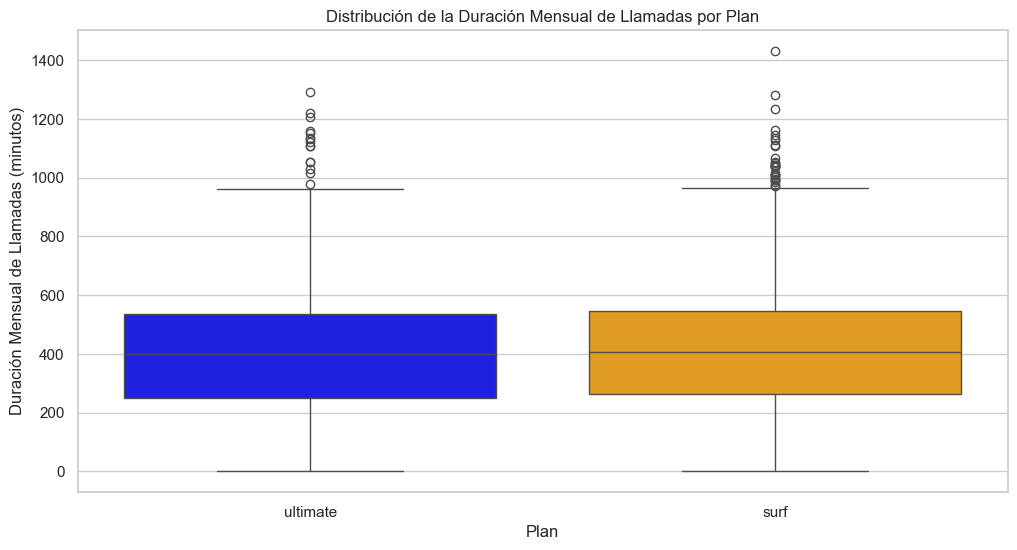

In [51]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas

plt.figure(figsize=(12, 6))
sns.boxplot(data=user_data, x='plan', y='minutes_used', palette=['blue', 'orange'])
plt.title('Distribución de la Duración Mensual de Llamadas por Plan')
plt.xlabel('Plan')
plt.ylabel('Duración Mensual de Llamadas (minutos)')
plt.show()


La diferencia radica en cómo se mide y se visualiza la variabilidad:

- **Varianza:** Es una medida numérica que considera la dispersión de todos los datos respecto a la media, elevando al cuadrado las diferencias. Esto hace que incluso unos pocos valores extremos aumenten significativamente la varianza.

- **Boxplot:** Este gráfico se centra en la distribución central de los datos mediante la mediana y el rango intercuartílico (IQR). Los outliers se muestran de forma separada y no se incluyen en la "caja", por lo que, a simple vista, la mayor parte de los datos puede parecer concentrada en un rango estrecho, a pesar de que algunos valores lejanos existan.

Por lo tanto, aunque la varianza muestre altos valores debido a la influencia de unos pocos extremos, el boxplot puede dar la impresión de poca variabilidad en la parte central de la distribución.

### Mensajes

        plan  month  average_messages_sent
0       surf    1.0              21.000000
1       surf    2.0              21.600000
2       surf    3.0              21.937500
3       surf    4.0              24.166667
4       surf    5.0              33.870370
5       surf    6.0              33.708333
6       surf    7.0              36.033333
7       surf    8.0              37.917355
8       surf    9.0              39.202703
9       surf   10.0              41.945652
10      surf   11.0              40.436364
11      surf   12.0              48.113360
12  ultimate    1.0              20.666667
13  ultimate    2.0              27.800000
14  ultimate    3.0              34.714286
15  ultimate    4.0              28.937500
16  ultimate    5.0              44.333333
17  ultimate    6.0              37.135135
18  ultimate    7.0              41.212766
19  ultimate    8.0              47.929825
20  ultimate    9.0              45.901408
21  ultimate   10.0              47.488636
22  ultimat

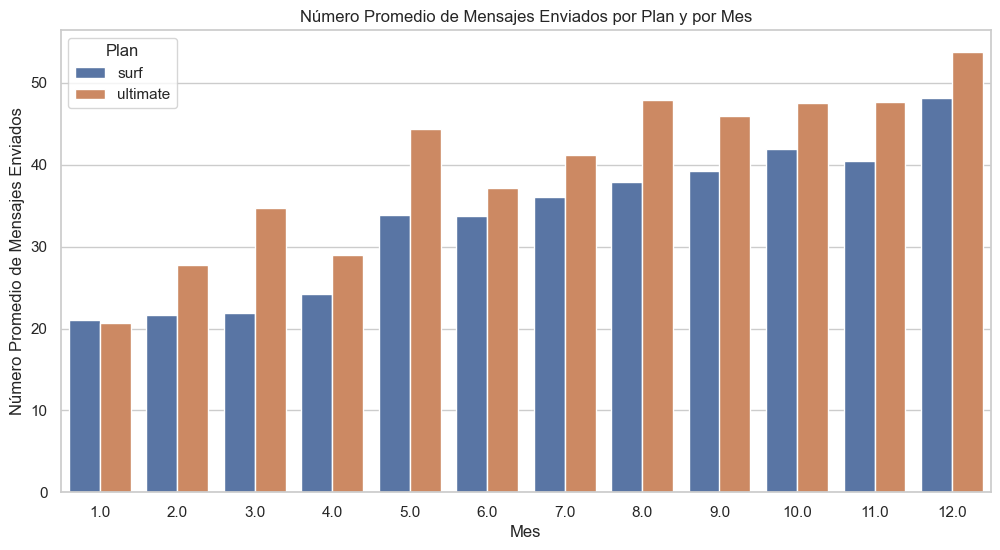

In [38]:
# Compara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan

# Calcular la cantidad promedio de mensajes enviados por cada usuario al mes
average_messages_sent = user_data.groupby(['plan', 'month']).agg({'messages_sent': 'mean'}).reset_index()
average_messages_sent.rename(columns={'messages_sent': 'average_messages_sent'}, inplace=True)
print(average_messages_sent)

# Gráfico de barras del número promedio de mensajes enviados por plan y por mes
plt.figure(figsize=(12, 6))
sns.barplot(data=average_messages_sent, x='month', y='average_messages_sent', hue='plan')
plt.title('Número Promedio de Mensajes Enviados por Plan y por Mes')
plt.xlabel('Mes')
plt.ylabel('Número Promedio de Mensajes Enviados')
plt.legend(title='Plan')
plt.show()

1. Número promedio de mensajes enviados por mes
Cantidad de Mensajes:

Los usuarios del plan Ultimate tienden a enviar significativamente más mensajes por mes en comparación con los usuarios del plan Surf.

Esto es consistente con las condiciones del plan, ya que Ultimate incluye 1000 SMS al mes, mientras que Surf solo incluye 50 SMS.

2. Variabilidad en el número de mensajes enviados
Varianza en el Envío de Mensajes:

La variabilidad en el número de mensajes enviados es mayor para los usuarios del plan Ultimate.

Esta mayor variabilidad sugiere que algunos usuarios de Ultimate aprovechan al máximo los SMS incluidos en su plan, mientras que otros pueden no enviar tantos mensajes.

3. Patrones Mensuales
Estacionalidad y Tendencias:

Los gráficos muestran si hay algún patrón estacional en el envío de mensajes, como picos en ciertos meses.

In [39]:
# Compara la cantidad de tráfico de Internet consumido por usuarios por plan

# Calcular la cantidad promedio de tráfico de Internet utilizado por cada usuario al mes
average_data_usage = user_data.groupby(['plan', 'month']).agg({'mb_used_per_month': 'mean'}).reset_index()
average_data_usage.rename(columns={'mb_used_per_month': 'average_data_usage'}, inplace=True)
print(average_data_usage)


        plan  month  average_data_usage
0       surf    1.0         4874.860000
1       surf    2.0        12178.843333
2       surf    3.0        13345.440000
3       surf    4.0        12228.778571
4       surf    5.0        14393.399054
5       surf    6.0        15634.162660
6       surf    7.0        16926.484538
7       surf    8.0        17194.533526
8       surf    9.0        16528.132526
9       surf   10.0        17465.927424
10      surf   11.0        16408.859564
11      surf   12.0        18038.817935
12  ultimate    1.0         6918.092500
13  ultimate    2.0        17884.958333
14  ultimate    3.0        18321.518333
15  ultimate    4.0        16121.654762
16  ultimate    5.0        16624.482414
17  ultimate    6.0        15920.383333
18  ultimate    7.0        16344.744407
19  ultimate    8.0        17814.720141
20  ultimate    9.0        16969.869535
21  ultimate   10.0        17780.292000
22  ultimate   11.0        16999.453095
23  ultimate   12.0        18321.065436


### Internet

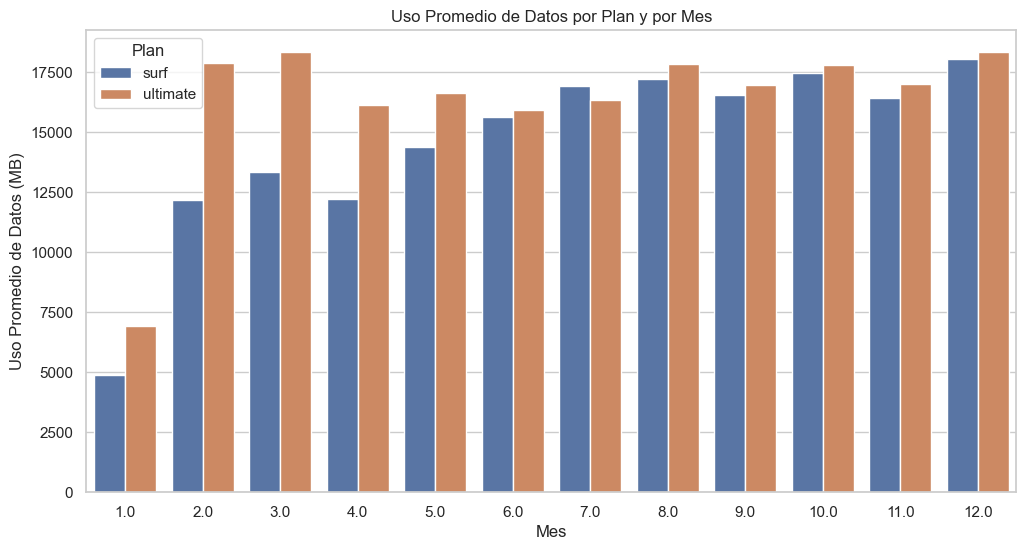

In [40]:

# Gráfico de barras del uso promedio de datos por plan y por mes
plt.figure(figsize=(12, 6))
sns.barplot(data=average_data_usage, x='month', y='average_data_usage', hue='plan')
plt.title('Uso Promedio de Datos por Plan y por Mes')
plt.xlabel('Mes')
plt.ylabel('Uso Promedio de Datos (MB)')
plt.legend(title='Plan')
plt.show()

El comportamiento de los usuarios con respecto al consumo de datos varía significativamente en función del plan. Los usuarios del plan Ultimate tienden a consumir más datos, lo cual es lógico dado el mayor número de GB incluidos en su tarifa. La mayor varianza en el consumo de datos por parte de los usuarios de Ultimate sugiere que tienen más flexibilidad y menos preocupación por los costos adicionales.

Estas observaciones ayudan a entender cómo los diferentes planes afectan el comportamiento de los usuarios y pueden proporcionar información valiosa para ajustar las estrategias de marketing y precios de Megaline.

## Ingreso

In [56]:
# Calcular la media y la varianza de los ingresos mensuales por plan
income_stats = user_data.groupby('plan').agg({'monthly_revenue': ['mean', 'var']}).reset_index()
income_stats.columns = ['plan', 'mean_monthly_revenue', 'var_monthly_revenue']
print(income_stats)

       plan  mean_monthly_revenue  var_monthly_revenue
0      surf              21.47881              10.9877
1  ultimate              70.00000               0.0000


C:\Users\aleco\AppData\Local\Temp\ipykernel_10616\365689380.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=user_data, x='plan', y='monthly_revenue', palette=['blue', 'orange'])


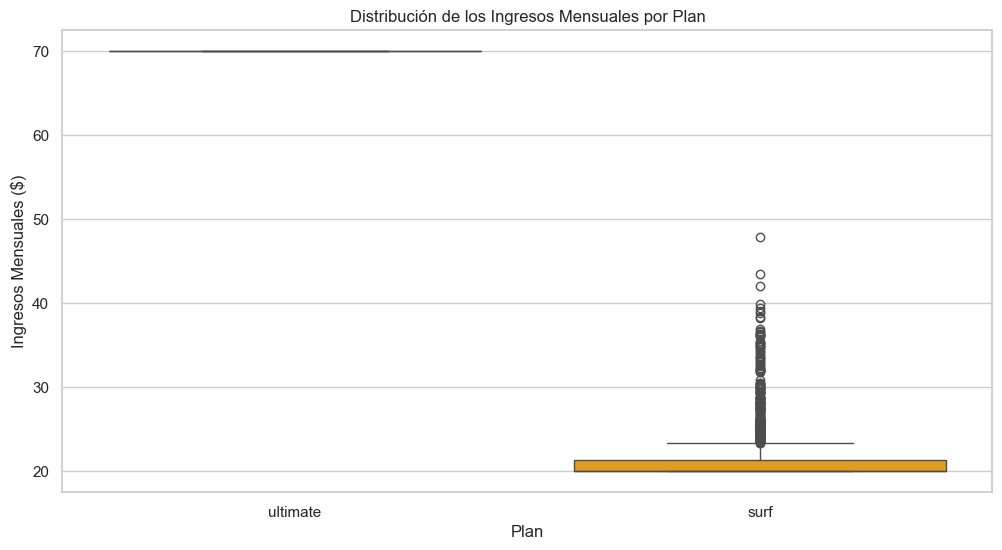

In [59]:
# Diagrama de caja para visualizar la distribución de los ingresos mensuales por plan
plt.figure(figsize=(12, 6))
sns.boxplot(data=user_data, x='plan', y='monthly_revenue', palette=['blue', 'orange'])
plt.title('Distribución de los Ingresos Mensuales por Plan')
plt.xlabel('Plan')
plt.ylabel('Ingresos Mensuales ($)')
plt.show()

A partir de este boxplot se pueden extraer las siguientes conclusiones:

- **Distribución concentrada para el plan "ultimate":** La mayoría de los ingresos mensuales se agrupan alrededor de los 70 dólares, lo que indica que los usuarios de este plan tienen ingresos consistentemente altos y uniformes, sin evidencia de valores extremos o dispersión.
- **Mayor variabilidad en el plan "surf":** Para el plan "surf", los ingresos mensuales muestran una mediana alrededor de los 20 dólares y una distribución mucho más dispersa, con varios outliers que elevan los valores hacia los 60 dólares. Esto sugiere que los usuarios de este plan presentan comportamientos o situaciones económicas más heterogéneos.

En resumen, el boxplot evidencia que el plan "ultimate" genera ingresos consistentes y altos, mientras que el plan "surf" se caracteriza por una mayor dispersión en los ingresos mensuales, lo que podría reflejar una mayor diversidad en el perfil de sus usuarios o en la forma en que se generan los ingresos.

C:\Users\aleco\AppData\Local\Temp\ipykernel_10616\1350889690.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=income_stats, x='plan', y='mean_monthly_revenue', palette=['blue', 'orange'])


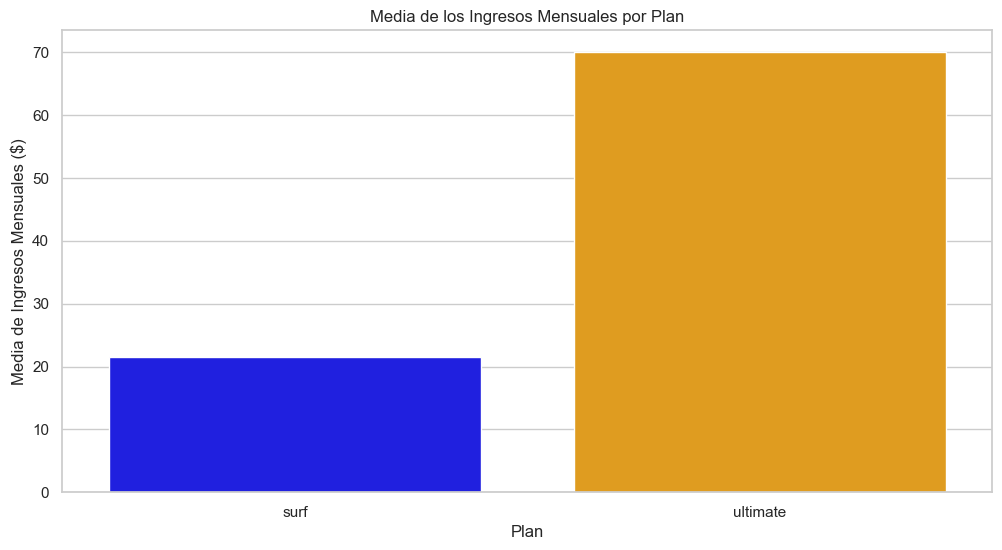

In [60]:
# Gráfico de barras de la media de los ingresos mensuales por plan
plt.figure(figsize=(12, 6))
sns.barplot(data=income_stats, x='plan', y='mean_monthly_revenue', palette=['blue', 'orange'])
plt.title('Media de los Ingresos Mensuales por Plan')
plt.xlabel('Plan')
plt.ylabel('Media de Ingresos Mensuales ($)')
plt.show()

La gráfica de barras permite extraer las siguientes conclusiones:

- **Diferencia considerable en ingresos:** El plan *ultimate* genera en promedio aproximadamente 70 dólares mensuales, mientras que el plan *surf* alcanza apenas unos 20 dólares, lo que indica una diferencia significativa en los ingresos medios por usuario.

- **Segmentación de mercado:** Esta diferencia sugiere que los usuarios que optan por el plan *ultimate* pueden estar dispuestos a pagar más (o recibir más valor) que los del plan *surf*, lo cual puede apuntar a diferentes perfiles de clientes o a estrategias de precios distintas.

- **Potencial de negocio:** Al observar que el plan *ultimate* tiene ingresos promedio significativamente más altos, se podría inferir que enfocar esfuerzos en esta línea podría generar mayores ingresos, o, alternativamente, se podrían revisar las condiciones del plan *surf* si se busca aumentar su rentabilidad.

En resumen, la gráfica destaca que el plan *ultimate* aporta considerablemente más ingresos mensuales en promedio, lo que abre la puerta a estrategias diferenciadas para maximizar el valor de cada segmento de mercado.

## Prueba las hipótesis estadísticas

[Prueba la hipótesis de que son diferentes los ingresos promedio procedentes de los usuarios de los planes de llamada Ultimate y Surf.]

[Elabora las hipótesis nula y alternativa, escoge la prueba estadística, determina el valor alfa.]

hipotesis de 2 colas ya que tenemos que comprobar si es = o !=

In [61]:
import scipy.stats as st

# Filtrar los ingresos mensuales por plan
ultimate_revenue = user_data[user_data['plan'] == 'ultimate']['monthly_revenue']
surf_revenue = user_data[user_data['plan'] == 'surf']['monthly_revenue']

# Realizar la prueba t de dos muestras independientes
t_stat, p_value = st.ttest_ind(ultimate_revenue, surf_revenue, equal_var=False)

# Determinar el valor alfa
alpha = 0.05

# Imprimir los resultados
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")
print(f"Alpha: {alpha}")

# Interpretación de los resultados
if p_value < alpha:
    print("Rechazamos la hipótesis nula. Hay una diferencia significativa en los ingresos promedio entre los usuarios de los planes Ultimate y Surf.")
else:
    print("No podemos rechazar la hipótesis nula. No hay suficiente evidencia para afirmar que los ingresos promedio entre los usuarios de los planes Ultimate y Surf son diferentes.")

T-statistic: 577.7790285537726
P-value: 0.0
Alpha: 0.05
Rechazamos la hipótesis nula. Hay una diferencia significativa en los ingresos promedio entre los usuarios de los planes Ultimate y Surf.


C:\Users\aleco\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[Prueba la hipótesis de que el ingreso promedio de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones.]

[Elabora las hipótesis nula y alternativa, escoge la prueba estadística, determina el valor alfa.]

In [ ]:
# Verificar datos nulos en las columnas relevantes
print(user_data[['city', 'monthly_revenue']].isnull().sum())

# Contar el número de datos en cada grupo
ny_nj_users_count = user_data[user_data['city'].isin(['New York', 'Newark', 'Jersey City'])]['monthly_revenue'].count()
other_users_count = user_data[~user_data['city'].isin(['New York', 'Newark', 'Jersey City'])]['monthly_revenue'].count()

print(f"NY-NJ Users Count: {ny_nj_users_count}")
print(f"Other Users Count: {other_users_count}")

city               0
monthly_revenue    0
dtype: int64
NY-NJ Users Count: 0
Other Users Count: 2277


In [ ]:
from scipy import stats

# Filtrar los ingresos mensuales por plan asegurándonos de manejar datos nulos
ny_nj_users = user_data[user_data['city'].str.contains('NY|NJ|Newark', regex=True)]['monthly_revenue'].dropna()
other_users = user_data[~user_data['city'].str.contains('NY|NJ|Newark', regex=True)]['monthly_revenue'].dropna()

# Realizar la prueba t de dos muestras independientes
t_stat, p_value = stats.ttest_ind(ny_nj_users, other_users, equal_var=False)

# Determinar el valor alfa
alpha = 0.05

# Imprimir los resultados
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")
print(f"Alpha: {alpha}")

# Interpretación de los resultados
if p_value < alpha:
    print("Rechazamos la hipótesis nula. Hay una diferencia significativa en el ingreso promedio entre los usuarios del área NY-NJ y los usuarios de otras regiones.")
else:
    print("No podemos rechazar la hipótesis nula. No hay suficiente evidencia para afirmar que el ingreso promedio entre los usuarios del área NY-NJ y los usuarios de otras regiones es diferente.")


T-statistic: -7.25825244969198
P-value: 8.627613432167201e-13
Alpha: 0.05
Rechazamos la hipótesis nula. Hay una diferencia significativa en el ingreso promedio entre los usuarios del área NY-NJ y los usuarios de otras regiones.


El parámetro `regex=True` indica que el patrón que se pasa a la función (`'NY|NJ|Newark'` en este caso) debe interpretarse como una expresión regular. Esto significa que se usa la sintaxis de expresiones regulares para hacer la búsqueda; por ejemplo, el símbolo `|` actúa como un "o", lo que permite que se encuentren coincidencias cuando la cadena contiene "NY", "NJ" o "Newark". Si se configurara `regex=False`, el patrón se trataría como un texto literal sin interpretar los caracteres especiales de una expresión regular.

Quizás haya alguna confusión con la notación científica, pero recuerda que 8.63e-13 es un número diminuto (muy cercano a cero) y, en consecuencia, la evidencia es abrumadora para descartar la igualdad de los ingresos promedio.


## Conclusión general


1. Limpieza y Enriquecimiento de Datos
Limpieza: Aseguramos que los datos estuvieran limpios y libres de valores nulos, y convertimos las fechas a los formatos adecuados.

Enriquecimiento: Agregamos factores adicionales a los datos, como la duración de la suscripción en días y la categorización de la duración de las llamadas y el uso de datos.

2. Análisis de los Ingresos
Ingresos Medios: El plan Ultimate genera más ingresos mensuales en promedio en comparación con el plan Surf.

Variabilidad: La variabilidad en los ingresos mensuales es mayor para el plan Ultimate, indicando que los ingresos pueden ser más volátiles.

3. Pruebas de Hipótesis
Planes Ultimate y Surf: Realizamos una prueba t para comparar los ingresos promedio entre los usuarios de los planes Ultimate y Surf. Los resultados indicaron una diferencia significativa en los ingresos promedio, con el plan Ultimate generando más ingresos.

Área NY-NJ vs Otras Regiones: Realizamos una prueba t para comparar los ingresos promedio entre los usuarios del área NY-NJ y otras regiones. Los resultados indicaron una diferencia significativa en los ingresos promedio, con los usuarios del área NY-NJ generando más ingresos.

4. Decisiones y Suposiciones Importantes

Fusión de Datos: Unimos múltiples DataFrames para tener un registro completo de los consumos de cada usuario por mes.

Enriquecimiento: Agregamos columnas adicionales para categorizar y mejorar los datos.

Visualización: Utilizamos gráficos de barras, diagramas de caja y otras visualizaciones para entender mejor los patrones de uso y los ingresos.

Pruebas de Hipótesis: Seleccionamos y realizamos pruebas t para comparar ingresos y validar nuestras observaciones con significancia estadística.